# Laboratory #3_1 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [138]:
# mount drive to the notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Face Detection using AdaBoost

In [139]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import color, data, io
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt

### Exercise #1

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [140]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on the original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    for i in range(1,integral_image_arr.shape[0]):
      for j in range(1,integral_image_arr.shape[1]):
        integral_image_arr[i,j] = integral_image_arr[i,j-1] + integral_image_arr[i-1,j] + img_arr[i-1,j-1] - integral_image_arr[i-1,j-1]
    return integral_image_arr

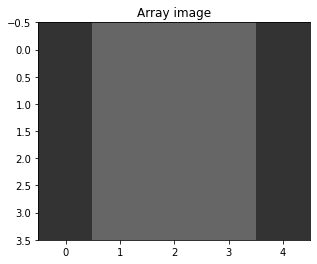

In [141]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [142]:
ii_img_array = compute_integral_image(img_array)
print(ii_img_array)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'integral Image')

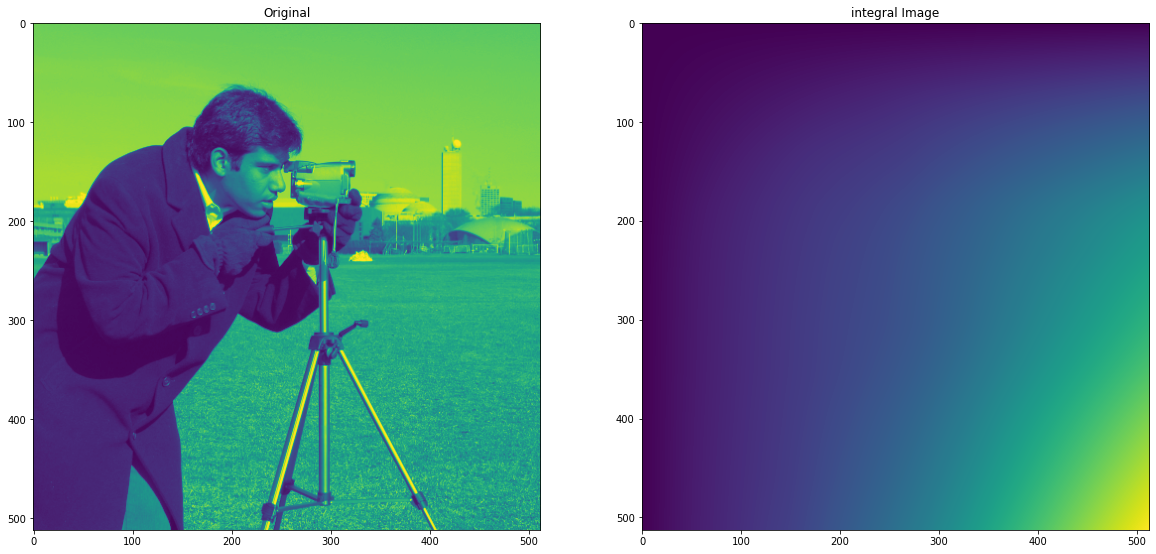

In [143]:
# solution
image = data.camera()
image_Gray = color.rgb2gray(image)
f, axarr = plt.subplots(1,2, figsize = (20,20))
axarr[0].imshow(image_Gray)
axarr[0].set_title("Original")
axarr[1].imshow(compute_integral_image(image_Gray))
axarr[1].set_title("integral Image")


### Exercise #2

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [144]:
def sum_region(integral_img_arr, top_left, bottom_right):
    output = integral_img_arr[bottom_right[0],bottom_right[1]] - integral_img_arr[bottom_right[0],top_left[1]] - integral_img_arr[top_left[0],bottom_right[1]] + integral_img_arr[top_left[0], top_left[1]]
    return output

*   Make the following tests:

In [145]:
# result you should get (12)
print(sum_region(ii_img_array, [1, 1], [3, 4]))

12.0


In [146]:
def sum_region(integral_img_arr, top_left, bottom_right):
    A, B, C, D = top_left, [top_left[0], bottom_right[1]], [bottom_right[0], top_left[1]], bottom_right
    return integral_img_arr[D[0], D[1]] - integral_img_arr[B[0], B[1]] - \
           integral_img_arr[C[0], C[1]] + integral_img_arr[A[0], A[1]] ###############################################################################################################

In [147]:
# result you should get (32)
print(sum_region(ii_img_array, [0, 0], [-1, -1]))

32.0


### Exercise #3

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [148]:
def load_integral_images(path):
    ii_images = []
    for _file in os.listdir(path):
      try:
        image = io.imread(path + "/" + _file)
        image_Gray = color.rgb2gray(image)
        integral_image = compute_integral_image(image_Gray)
        integral_image = integral_image/integral_image.max()
        ii_images.append(integral_image)
      except: #If the folder contains non-pictures they are not returned
        pass

    return ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

*   Use the load_integral_images function to compute the integral images of training and testing data

In [149]:
# change paths to your location

root_dir = '/content/drive/MyDrive/Colab Notebooks/images6'

pos_training_path = os.path.join(root_dir, 'train_data/faces')
neg_training_path = os.path.join(root_dir, 'train_data/non_faces')
pos_testing_path = os.path.join(root_dir, 'test_data/faces')
neg_testing_path = os.path.join(root_dir, 'test_data/non_faces')

In [150]:
# solution
pos_training_integral = load_integral_images(pos_training_path)
neg_training_integral = load_integral_images(neg_training_path)
pos_testing_integral = load_integral_images(pos_testing_path)
neg_testing_integral = load_integral_images(neg_testing_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


*   Visualize a few original images and the corresponding integral images using matplotlib.

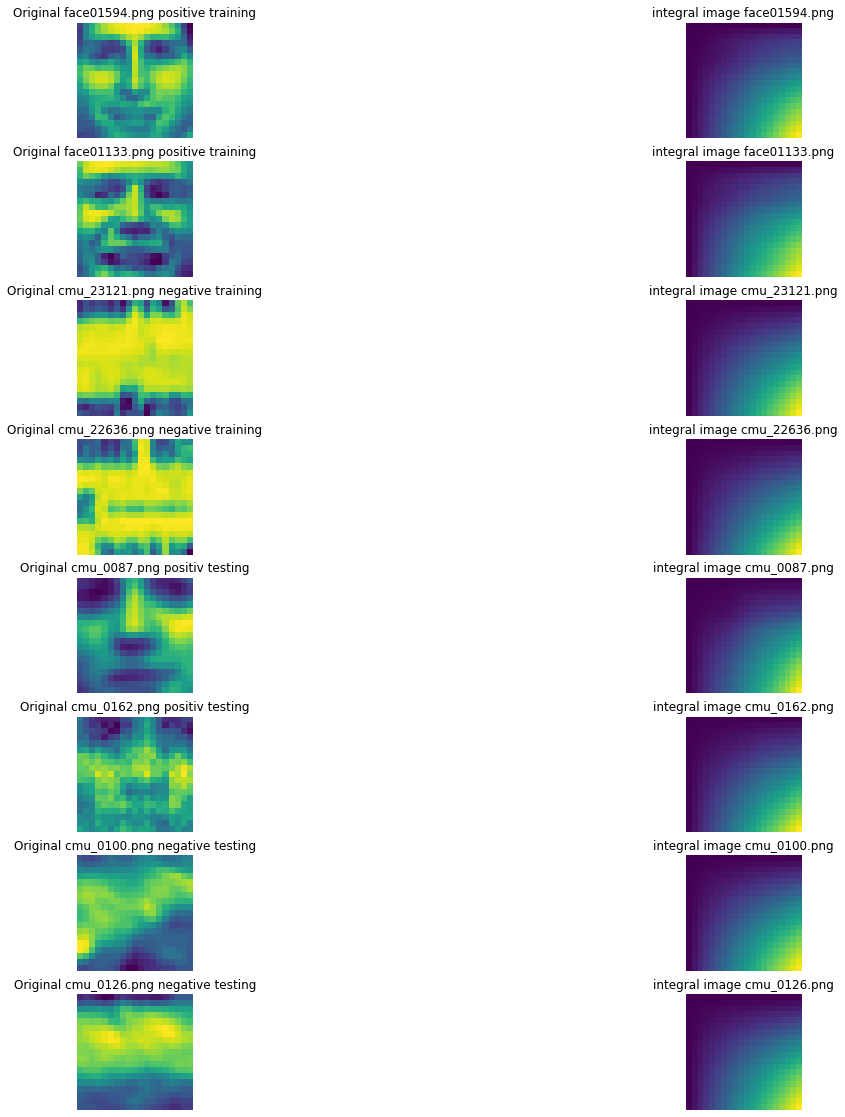

In [151]:
# solution
index = 0
f, axarr = plt.subplots(8,2, figsize = (20,20))
for image_type, type_name, path in  zip([pos_training_integral,neg_training_integral,pos_testing_integral,neg_testing_integral],
                                        ["positive training", "negative training", "positiv testing", "negative testing"], 
                                        [pos_training_path,neg_training_path,pos_testing_path,neg_testing_path]):
    _files = os.listdir(path)
    for i in [1,10]:
      axarr[index,0].imshow(io.imread(path + "/" + _files[i]))
      axarr[index,0].set_title("Original " + _files[i] + " " + type_name)
      axarr[index,0].axis("off")
      axarr[index,1].imshow(image_type[i])
      axarr[index,1].set_title("integral image " + _files[i])
      axarr[index,1].axis("off")
      index += 1  



### Exercise #4

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [152]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [153]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [154]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
    
                for y in range(img_height - feature_height):
                    for x in range(img_width - feature_width):
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1))

                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
            
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Haar-like features:', time.time()-t0)
    return features

### Exercise #5

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [155]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [156]:
# solution


%%time 

classifiers = learn(pos_training_integral,neg_training_integral,num_classifiers,min_feature_width,max_feature_width,min_feature_height,max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.00732111930847168
Calculating scores for images..
	Time needed for calculating scores: 349.1494266986847
Selecting classifiers..
	Time needed for Selecting Classifiers: 46.53255271911621 

CPU times: user 2min 36s, sys: 9.14 s, total: 2min 45s
Wall time: 6min 35s


### Exercise #6

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [157]:
# Clasify an integral image based on the mayority of votes from a list of classifiers
def ensemble_vote(int_img, classifiers):
  trueVotes = 0
  for classifier in classifiers:
    trueVotes += int(classifier.get_vote(int_img) > 0)
  return trueVotes > len(classifiers)/2

# Clasify a list of integral image
def ensemble_vote_all(int_imgs, classifiers):
  votes= np.zeros(len(int_imgs))
  for image in range(len(int_imgs)):
    votes[image] = ensemble_vote(int_imgs[image],classifiers)
  return votes






*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [158]:
from numpy.ma.core import count
# solution

#Concatinating the output to a string
def PrintResult(pictures,classifiers, invert = False):
  trueIdentified = sum(ensemble_vote_all(pictures,classifiers))
  if invert:
    trueIdentified = len(pictures) - trueIdentified
  return("{}/{}  ({}%)".format(int(trueIdentified),len(pictures),trueIdentified*100/len(pictures)))

print("train results:")
print("Correctly identified Faces:",PrintResult(pos_training_integral,classifiers))
print("Correctly identified non-Faces:",PrintResult(neg_training_integral,classifiers, invert = True),"\n")

print("test results:")
print("Correctly identified Faces:",PrintResult(pos_testing_integral,classifiers))
print("Correctly identified non-Faces:",PrintResult(neg_testing_integral,classifiers, invert = True))






train results:
Correctly identified Faces: 1854/2429  (76.3277068752573%)
Correctly identified non-Faces: 6326/8555  (73.94506136762128%) 

test results:
Correctly identified Faces: 221/472  (46.82203389830509%)
Correctly identified non-Faces: 102/128  (79.6875%)


### Exercise #7

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [159]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [160]:
# solution

%%time 

classifiers_20 = learn(pos_training_integral,neg_training_integral,num_classifiers,min_feature_width,max_feature_width,min_feature_height,max_feature_height)




Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.007730722427368164
Calculating scores for images..
	Time needed for calculating scores: 327.9731307029724
Selecting classifiers..
	Time needed for Selecting Classifiers: 439.5399181842804 

CPU times: user 8min 53s, sys: 11.1 s, total: 9min 4s
Wall time: 12min 47s


In [161]:
print("train results:")
print("Correctly identified Faces:",PrintResult(pos_training_integral,classifiers_20))
print("Correctly identified non-Faces:",PrintResult(neg_training_integral,classifiers_20, invert=True),"\n")

print("test results:")
print("Correctly identified Faces:",PrintResult(pos_testing_integral,classifiers_20))
print("Correctly identified non-Faces:",PrintResult(neg_testing_integral,classifiers_20, invert=True))


train results:
Correctly identified Faces: 1826/2429  (75.17496912309592%)
Correctly identified non-Faces: 7912/8555  (92.48392752776154%) 

test results:
Correctly identified Faces: 152/472  (32.20338983050848%)
Correctly identified non-Faces: 118/128  (92.1875%)


*   Discuss if the classification results improved in the train data.


**Solution**

The classification result for the detection of faces didn't change significantly in the training result, but it decreased slightly in the test result. This indicates some signs of possible overfitting, due to the increment of features for the same size of data.
The detection of Non-faces increased significantly for both the training set and the test sets. The largest improvement occurred in the test set, indicating possible overfitting.

...

### Exercise #8

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [162]:
# solution

#Alternative with use of threshold for total score of votes
def ensemble_vote_t(int_img, classifiers, threshold):
    totslScore = sum([classifier.get_vote(int_img) for classifier in classifiers]) 
    return int(totslScore > threshold)

# alternative use with threshold for each vote indivitually
# def ensemble_vote_t(int_img, classifiers, threshold):
#   trueVotes = 0
#   for classifier in classifiers:
#     trueVotes += int(classifier.get_vote(int_img) > threshold)
#   return trueVotes > len(classifiers)/2


def ensemble_vote_all_t(int_imgs, classifiers,threshold):
  votes= np.zeros(len(int_imgs))
  for image in range(len(int_imgs)):
    votes[image] = ensemble_vote_t(int_imgs[image],classifiers,threshold)
  return votes

*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [163]:
# solution
thresholds = np.array([x for x in range(-5,5,1)])/10
accuraciesFacesTrain = []
accuraciesNonFacesTrain = []
accuraciesFacesTest = []
accuraciesNonFacesTest = []

for threshold in thresholds:
  accuraciesFacesTrain.append(sum(ensemble_vote_all_t(pos_training_integral,classifiers_20,threshold))/len(pos_training_integral))
  accuraciesNonFacesTrain.append((len(neg_training_integral) - sum(ensemble_vote_all_t(neg_training_integral,classifiers_20,threshold)))/len(neg_training_integral))
  accuraciesFacesTest.append(sum(ensemble_vote_all_t(pos_testing_integral,classifiers_20,threshold))/len(pos_testing_integral))
  accuraciesNonFacesTest.append((len(neg_testing_integral) - sum(ensemble_vote_all_t(neg_testing_integral,classifiers_20,threshold)))/len(neg_testing_integral))



*   Make a bar plot for 1-4. In the x axis write the threshold value.

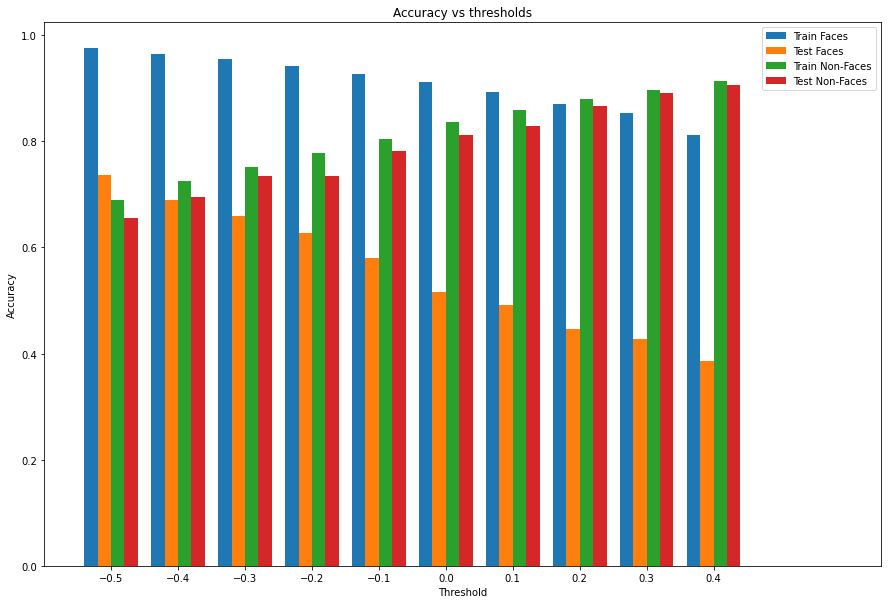

In [164]:
# solution
plt.figure(figsize=(15, 10))


plt.bar(thresholds - 0.030, accuraciesFacesTrain, width=0.02, align='center', label='Train Faces')

plt.bar(thresholds - 0.010, accuraciesFacesTest, width=0.02, align='center', label='Test Faces')

plt.bar(thresholds + 0.010, accuraciesNonFacesTrain, width=0.02, align='center', label='Train Non-Faces')

plt.bar(thresholds + 0.030, accuraciesNonFacesTest, width=0.02, align='center', label='Test Non-Faces')

plt.title('Accuracy vs thresholds')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.xlim(-0.6, 0.65)
plt.xticks(thresholds)

plt.show()


*   Discuss what happens when you increase the threshold value.

**Solution**

When the threshold increases, the number of detected faces decreases, while the number of detected non-faces increases. This is in accordance with the threshold purpose, in which it is set the minimum score allowed to detect faces.

Overall, it is stated that the accuracy of the test result decreases more than that of the training result.

It is difficult to decide on a reasonable boundary since this test only shows true positive and true negative. So, to find a suitable threshold the test set should contain both faces and non-faces. In general, if it is important to detect all faces, the threshold should be low, however, if the main aim is to avoid false positives, the threshold should be high.

In addition to this test, it was tested with another voting method (commented out). This set a threshold for each vote to count, instead of the sum of each vote combined. This gives similar results but needs shorter intervals in the threshold values.
...

# Face Recognition using PCA


In [165]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

*   Loading the dataset

In [166]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


*   Creating training and testing set

In [167]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Number of classes in Train set:', np.unique(y_train).shape[0])

Train data shape: (966, 1850)
Test data shape: (322, 1850)
Number of classes in Train set: 7


### Exercise #1: PCA Computation
*   Compute a PCA (eigenfaces) on the face dataset
    *   *Set* number of components to 100

In [168]:
# Define the number of components required
num_components = 100
# Apllying PCA
pca = PCA(n_components = num_components).fit(X_train)


*   Reshape the components output of pca to obtain the eigen faces

In [169]:
# Getting the components from PCA
pca_components = pca.components_
# Getting the eigen faces
eigen_faces = pca_components.reshape((num_components, h, w))


*   Project the training and testing faces data on the orthonormal basis

In [170]:
# Dimensionality reduction on the training and test data
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)


*   Plot the most significative eigenfaces (Show the top 12 eigenfaces) as a matplotlib

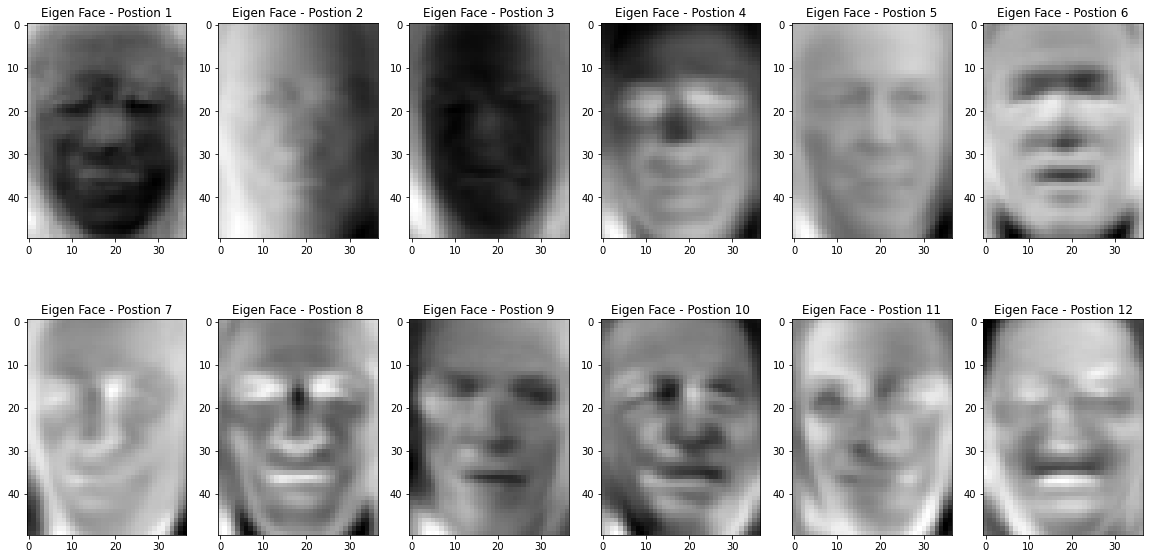

In [171]:
f, axarr = plt.subplots(2,6, figsize = (20,10))
for id in range(0, 6):

  # 1st row
  axarr[0][id].imshow(eigen_faces[id], cmap = 'gray')
  axarr[0][id].set_title('Eigen Face - Postion ' + str(id +1))

  # 2nd row
  axarr[1][id].imshow(eigen_faces[id + 6], cmap = 'gray')
  axarr[1][id].set_title('Eigen Face - Postion ' + str(id + 1 + 6))


*   Show the total percentage of variance explained by the selected components of the PCA.


In [172]:
# Percentage of variance explained 
pca.explained_variance_ratio_


array([0.19346519, 0.15116845, 0.07083682, 0.05951791, 0.05157495,
       0.02887154, 0.02514484, 0.02176465, 0.0201938 , 0.01902123,
       0.01682212, 0.01580598, 0.01223363, 0.01087938, 0.01064452,
       0.00979653, 0.00892399, 0.00854845, 0.00835711, 0.00722636,
       0.00696569, 0.00653857, 0.00639558, 0.00561317, 0.00531107,
       0.00520152, 0.00507466, 0.00484209, 0.00443588, 0.00417829,
       0.00393705, 0.00381728, 0.00356061, 0.00351201, 0.00334556,
       0.0032993 , 0.00314626, 0.00296217, 0.00290135, 0.00284722,
       0.00280003, 0.00267555, 0.00259898, 0.002584  , 0.00240916,
       0.00238993, 0.00235401, 0.00222581, 0.00217503, 0.00216556,
       0.00209055, 0.00205422, 0.00200414, 0.00197391, 0.00193821,
       0.00188731, 0.0018016 , 0.00178883, 0.00174788, 0.00173018,
       0.00165627, 0.0016291 , 0.00157379, 0.00153389, 0.00149907,
       0.0014722 , 0.00143807, 0.00141799, 0.00139404, 0.00138031,
       0.00133815, 0.00133105, 0.00128617, 0.00125312, 0.00123

*   What are the shortcomings of PCA?

**Solution**

*   The main limitations of PCA are the following:
    1. During the dimensionality reduction process assumes that the components are linear combinations of the original features.
    2. PCA assumes that the components are orthogonal.
    3. The dimensionality reduction is useful, however, is not possible to preserve integrally the information. Thus, there is always a trade-off between dimensionality reduction and information loss.
    4. It is sensitive to the scale of the features.
    5. In the presence of outliers PCA is biased.

...

### Exercise #2: k-NN Classification

*   Train a k-nearest neighbor model with the eigenfaces using the default parameters

In [173]:
# Training the k-nearest neighbor model
KNN_def = KNeighborsClassifier()
KNN_classifier = KNN_def.fit(X_train_transformed, y_train)


*   Predict the test data using the trained classifier

In [174]:
# Quantitative evaluation of the model quality on the test set
# KNN model Prediction
y_pred = KNN_classifier.predict(X_test_transformed)
print(y_pred)


[3 3 3 3 3 3 6 1 3 3 3 3 3 3 3 3 1 3 3 2 1 0 3 1 0 1 1 3 3 3 3 3 3 3 3 3 1
 1 3 3 3 1 3 6 3 1 6 3 3 3 3 3 3 3 3 2 2 5 3 3 1 1 4 1 0 3 1 6 1 3 1 6 1 3
 3 2 1 3 1 3 3 0 4 3 3 2 3 2 6 3 3 3 3 3 1 5 1 1 3 6 3 3 3 3 3 4 3 3 5 3 3
 1 3 3 4 3 0 3 1 3 1 3 3 0 3 4 4 3 1 1 3 3 3 3 3 2 3 3 2 1 3 2 5 1 3 5 1 3
 2 1 3 2 3 5 4 3 1 3 2 3 6 5 3 1 3 1 5 1 2 3 3 1 3 1 4 3 3 2 2 3 1 3 1 1 6
 2 3 3 3 2 3 2 3 3 6 3 3 3 3 3 5 2 3 1 3 3 3 2 1 3 1 3 3 3 3 3 3 2 1 2 1 3
 1 1 1 3 3 3 0 3 3 1 3 0 3 3 1 3 3 3 3 1 2 3 3 1 3 1 0 6 4 3 3 3 3 2 1 1 1
 0 3 3 1 1 3 3 1 1 3 6 1 1 3 3 6 2 3 3 1 6 1 1 3 3 1 3 3 5 3 3 1 3 5 0 3 3
 4 5 3 3 3 3 6 2 1 3 0 4 1 3 3 3 3 3 3 3 6 3 3 3 1 3]


### Exercise #3: Quantitative results

*   Compute accuracy, classification report and confusion matrix of the trained classifier

In [175]:
# Accuracy
accuracy_score(y_test, y_pred)


0.577639751552795

In [176]:
# Classification Report
print(classification_report(y_test, y_pred, target_names=target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.31      0.32        13
     Colin Powell       0.51      0.60      0.55        60
  Donald Rumsfeld       0.42      0.41      0.42        27
    George W Bush       0.66      0.79      0.72       146
Gerhard Schroeder       0.45      0.20      0.28        25
      Hugo Chavez       0.50      0.40      0.44        15
       Tony Blair       0.56      0.25      0.35        36

         accuracy                           0.58       322
        macro avg       0.49      0.42      0.44       322
     weighted avg       0.56      0.58      0.56       322



In [177]:
# Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[  4,   2,   2,   5,   0,   0,   0],
       [  3,  36,   5,  13,   1,   1,   1],
       [  2,   6,  11,   8,   0,   0,   0],
       [  3,  12,   4, 115,   4,   5,   3],
       [  0,   4,   3,  10,   5,   0,   3],
       [  0,   3,   0,   5,   1,   6,   0],
       [  0,   7,   1,  19,   0,   0,   9]])

*   Explain the measures showed in the classification report.
*   Discuss the obtained classification results, both the quantitative as well as the qualitative results.



**Quantitative**

*   The classification report evaluates the accuracy (percentage of correct labels), macro accuracy (average of the unweighted mean per label) and weighted average (average of the support-weighted mean per label) based on the following 4 metrics:
    1. Precision: the percentage of correct positive predictions relative to the total positive predictions.
    2. Recall: the percentage of correct positive predictions relative to the true total positives.
    3. F1-Score: A weighted harmonic mean of precision and recall. A value closer to 1 indicates a good model, while 0 points out a bad model.
    4. Support: indicates how many observations belong to each class in the test set.

*   Firstly, it is important to denote that the number of observations per label in the test set is not balanced. For example, while George W Bush is represented 146 times (45%), Ariel Sharon and Hugo Chavez only have representation of 13 (4%) and 15 (5%), respectively. Consequentially, the conclusions relative to the precision, recall and F1-Scores are not equally grounded independently of the label. In other words, while it is possible to effectuate a suitable evaluation of the model in identifying George W Bush, the same conclusion cannot be made relative to Ariel Sharon or Hugo Chavez, for example.

*   In terms of the three metrics (precision, recall and F1-Score) it is noticeable that George W Bush is, by a considerable margin, the best-classified label (F1-Score = 71%), with the lowest number of false positives (34%). On the other hand, Ariel Sharon is the label with the highest score of false positives (67%). However, Tony Blair's label seems to be the label where less positive results are detected (recall = 22%), even though it is the second most precise label (53%) to be classified.
Colin Powell, the second most represented label (60 observations) reaches an F1-Score of 55%, roughly similar to the overall accuracy (57%). In general, with the exception of George W Bush and Colin Powell, the model performs significantly poorly, however, as said previously, it is not possible to accomplish grounded conclusions with a diminished portion of observations in the majority of the labels.


*   In the accuracy scores the micro average is the most complete one since it considers True Positives (TP), False Negatives (FN), and False Positives (FP), the reason why it only appears in the F1-Score column. The macro and weighted averages are also useful, but due to their simplicity, they might not be used in every application.

**Qualitative**

*   In order to analyse the qualitative results, it is taken into account the confusion matrix obtained, which is a qualitative representation of the classification report.
Particularly, the horizontal (or the columns) correspond to predicted labels and the vertical (or the rows) are relative to the true labels. Accordingly, the main diagonal of the matrix indicates the number of predictions of a certain layer that were correctly classified.

*   For instance, if it is considered the label George W Bush (4th row and column) the value of TP is 114, which is divided by 146 resulting in 78% (the recall value). Furthermore, if 114 is divided by 174 (the number of positive predictions or the sum of the 4th column values) it is obtained the precision measurement of 66%. Thus, the F1-score of 71% is obtained by applying the formula:

    *F1-Score = 2.(Precision.Recall) / (Precision+Recall)*

    In general, from George W Bush's label perspective the confusion matrix can be viewed as:


       [ TN,   -,   -,  FP,   -,   -,   -],

       [  -,  TN,   -,  FP,   -,   -,   -],

       [  -,   -,  TN,  FP,   -,   -,   -],

       [ FN,  FN,  FN,  TP,  FN,  FN,  FN],

       [  -,   -,   -,  FP,  TN,   -,   -],

       [  -,   -,   -,  FP,   -,  TN,   -],

       [  -,   -,   -,  FP,   -,   -,  TN]

...

### Exercise #4

*   How is the optimal value of 'k' found?

**Solution**

*   As the k-nearest neighbour model is categorized as supervised learning, the output labels are accessible. Thus, by computing several values for k and comparing the accuracies or error values, it is inferable the optimal k that maximizes the accuracy/minimizes the error of the prediction (as it is illustrated by the graph in the subsequent code cell).

    The value of k can vary from 1 (one neighbour considered) to the maximum number of observations minus one (all the remaining data points are considered).

...

*   Use GridSearch to find the optimal value of 'k'.
    *   *Hint: GridSearchCV is available in sklearn.model_selection*
*   What is the accuracy of the best estimator?

Optimal number of neighbors:  7
Optimal accuracy:  56.837414089347085


Text(0, 0.5, 'Accuracy')

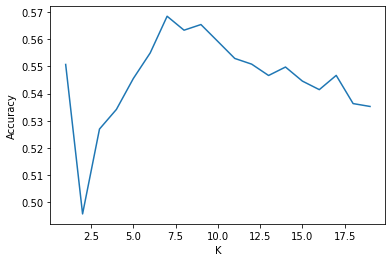

In [178]:
# Grid Definition
parameters_grid = dict(n_neighbors = list(range(1, 20)))
# Training process
GS_KNN = GridSearchCV(KNN_def, parameters_grid, cv=10, scoring='accuracy').fit(X_train_transformed, y_train)
# Optimal number of neighbors
print('Optimal number of neighbors: ', GS_KNN.best_params_['n_neighbors'])
# Accuracy of the optimal number of neighbors
print('Optimal accuracy: ', GS_KNN.best_score_ *100)

# Visual representation of the GridSearchCV process
GS_MS = GS_KNN.cv_results_['mean_test_score']
plt.plot(range(1, 20), GS_MS)
plt.xlabel('K')
plt.ylabel('Accuracy')


### Exercise #5: Qualitative evaluation

*   Plot some of the prediction images using matplotlib subplots (4 x 4). Show the true label and predicted label as the title of each sub plot.

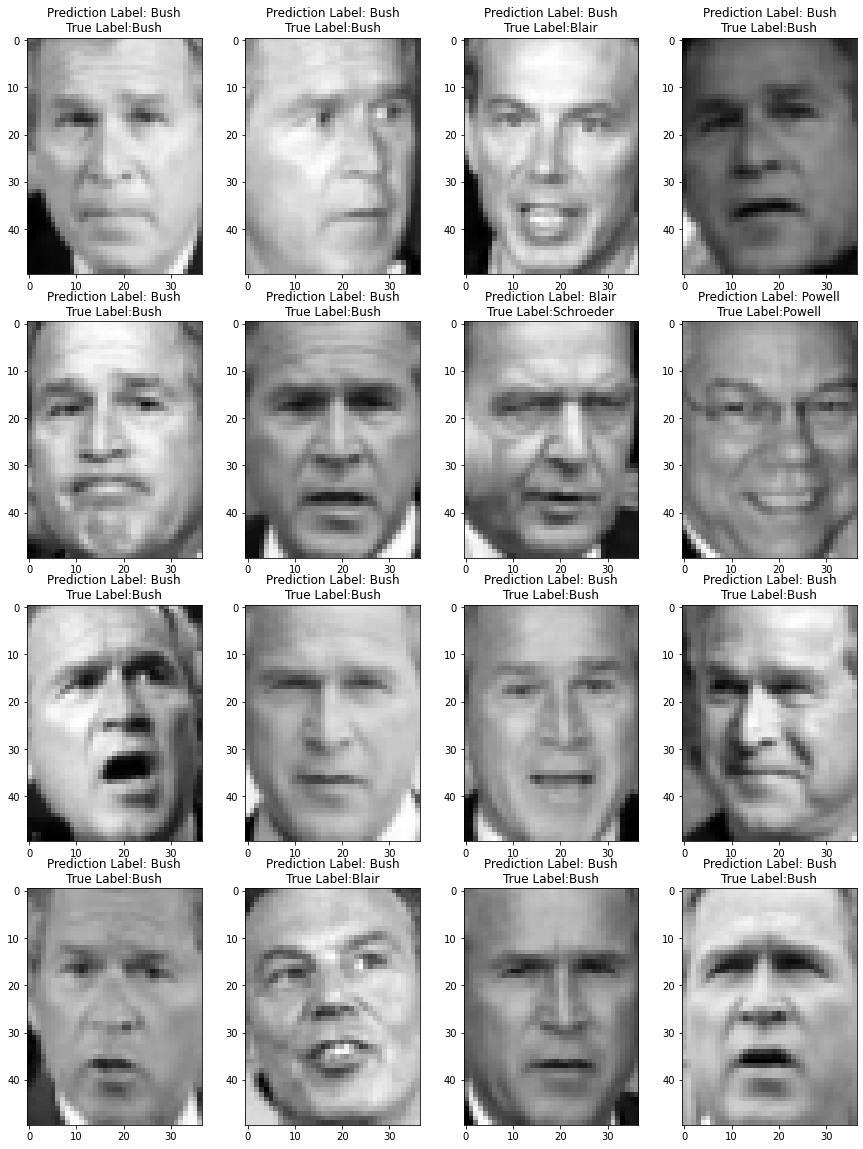

In [179]:
# Subplot
plt.figure(figsize=(15, 20))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].reshape((h, w)), cmap='gray')
  plt.title('Prediction Label: ' + target_names[y_pred[i]].rsplit(' ', 1)[-1] + '\n' + 'True Label:' + target_names[y_test[i]].rsplit(' ', 1)[-1])

*   What are the disadvantages of using kNN

**Solution**

*   The main disadvantages of using KNN are:
    1. In large datasets the time and memory complexity can be significant.
    2. For the same previous reason, it is not adequable to be applied in high dimensionality data.
    3. It is sensitive to noisy and missing data.
    4. Requires feature scaling priorly.
    5. Imbalanced data can be a problem.
...


---

# **End of L3_1: Face Detection and Recognition**
Deadline for L3_1 submission in CampusVirtual is: **Thursday, the 10th of November, 2022**